# Random Forest

## Import Data

In [ ]:
import pandas as pd

train_df = pd.read_parquet("../data/train_non_lin_preprocessed.parquet")
print(train_df.shape)

X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']

test_df = pd.read_parquet("../data/test_non_lin_preprocessed.parquet")
print(test_df.shape)

X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

(1076248, 80)
(269062, 80)


## Modelling

### Imbalanced Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

target_col = "target"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [11]:
def build_rf(n_estimators, max_depth, class_weight=None):

    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    print("Test ROC AUC:", roc_auc_score(y_test, y_proba).round(4))
    print(classification_report(y_test, y_pred))

    return(rf_model, y_pred, y_proba)

rf, y_pred, y_proba = build_rf(50,15)

Test ROC AUC: 0.7208
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    215350
           1       0.58      0.06      0.12     53712

    accuracy                           0.80    269062
   macro avg       0.69      0.53      0.50    269062
weighted avg       0.76      0.80      0.74    269062



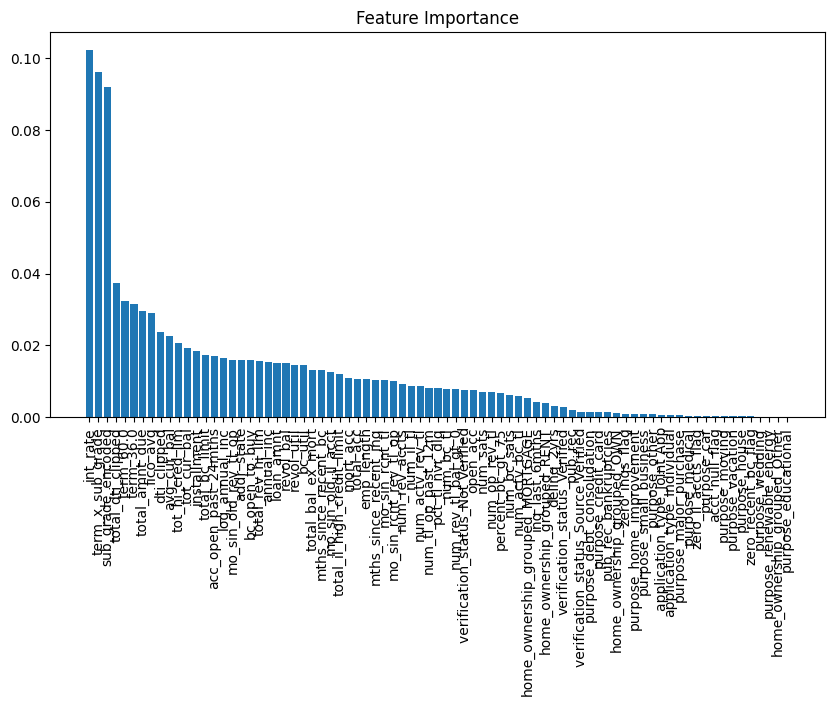

In [8]:
def plot_feature_importances(rf):

    importances = rf.feature_importances_
    feature_names = X_train.columns

    # Sort by importance
    sorted_idx = importances.argsort()[::-1]

    plt.figure(figsize=(10,5))
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
    plt.title("Feature Importance")
    plt.show()

plot_feature_importances(rf)

### Balanced Random Forest

In [14]:
rf, y_pred, y_proba = build_rf(50,15,'balanced')

Test ROC AUC: 0.7182
              precision    recall  f1-score   support

           0       0.87      0.72      0.79    215350
           1       0.34      0.59      0.43     53712

    accuracy                           0.69    269062
   macro avg       0.61      0.65      0.61    269062
weighted avg       0.77      0.69      0.72    269062



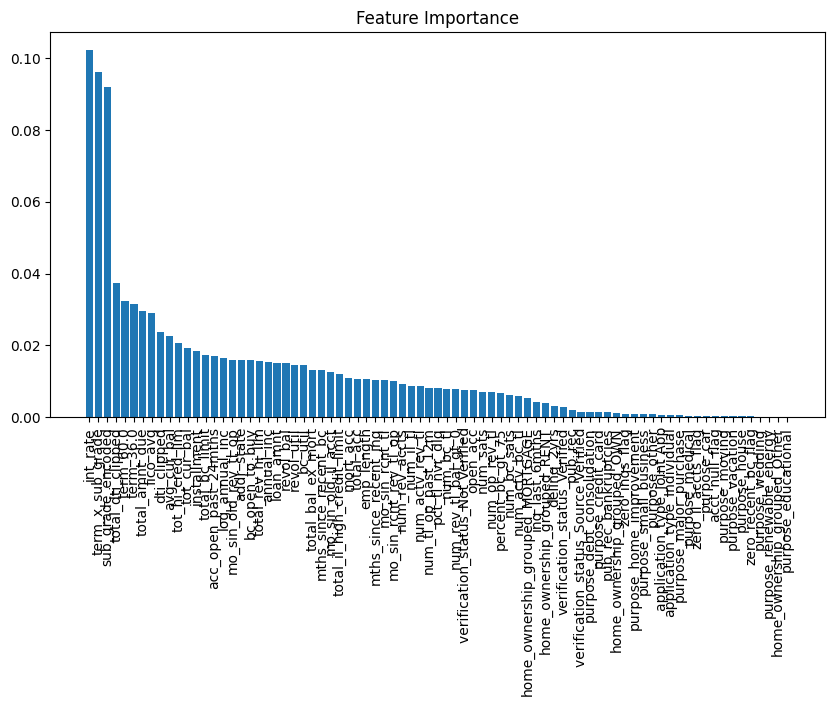

In [15]:
plot_feature_importances(rf)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc.round(4))

PR AUC: 0.3848263435995586


Note that this gives a similar ROC AUC, but is much better on the positive class.

### Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import train_test_split, ParameterGrid

In [ ]:
# The dataset is too large to use cross validation with multiple folds to tune hyperparameters
# so let's take a small sample of the data instead
# I originally used a 10% sample but increased it after narrowing down the parameter grid

train_sample = train_df.sample(frac=0.25, random_state=42)
X_sample = train_sample.drop(columns=["target"])
y_sample = train_sample["target"]

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

In [53]:
def get_model_scores(model):

    y_proba = model.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, y_proba).round(4)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision).round(4)

    print()
    print(f"Final ROC AUC: {roc} | PR AUC: {pr_auc}")

    return(roc, pr_auc)


def fit_final_model(params):

    final_model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Handle imbalance
    )

    final_model.fit(X_train, y_train)

    roc, pr_auc = get_model_scores(final_model)

    return final_model, roc, pr_auc


def tune_rf(param_grid, final_model_bool=False):

    best_auc = 0
    best_params = {}

    for params in ParameterGrid(param_grid):
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            max_features=params['max_features'],
            random_state=42,
            n_jobs=3,
            class_weight='balanced'  # Handle imbalance
        )

        model.fit(X_train_sub, y_train_sub)

        y_proba = model.predict_proba(X_val_sub)[:, 1]
        roc = roc_auc_score(y_val_sub, y_proba)

        precision, recall, _ = precision_recall_curve(y_val_sub, y_proba)
        pr_auc = auc(recall, precision)

        if roc > best_auc:
            best_auc = roc
            best_params = params
            best_params_pr_auc = pr_auc
    
    print()
    print("Best params:", best_params, "| Best Validation AUC:", best_auc.round(4), "| Validation PR AUC:", best_params_pr_auc.round(4))

    if final_model_bool:
        final_model, roc, pr_auc = fit_final_model(best_params)
        return (best_params, final_model, roc, pr_auc)
    
    else:
        return (best_params, roc, pr_auc)

In [55]:
# Note that I first narrowed down param_grid and I'm now looking more locally.

param_grid = {
    'n_estimators': [150, 175, 200],
    'max_depth': [10, 12, 15],
    'max_features': ['sqrt'],
}

# best_params, roc, pr_auc = tune_rf(param_grid)
best_params, final_model, roc, pr_auc = tune_rf(param_grid, True)


Best params: {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 175} | Best Validation AUC: 0.7164 | Validation PR AUC: 0.3804

Final ROC AUC: 0.7196 | PR AUC: 0.3868


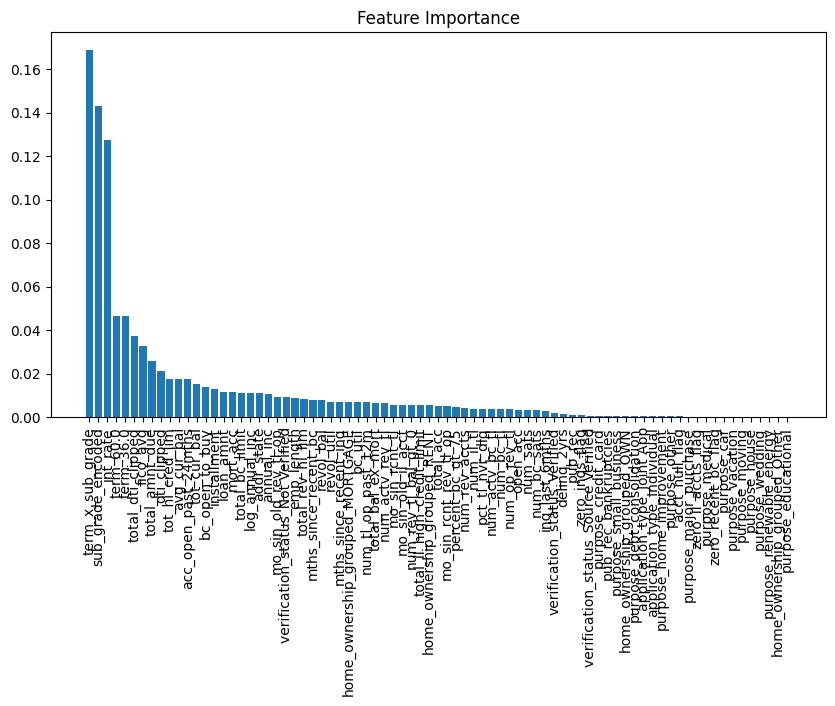

In [56]:
plot_feature_importances(final_model)

In [ ]:
# def tune_rf(n_estimators, n_splits, param_grid):

    # rf_model = RandomForestClassifier(
    #     n_estimators=n_estimators,
    #     random_state=42,
    #     n_jobs=-1,
    #     class_weight='balanced'  # Handle imbalance
    # )

#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

#     grid_search = GridSearchCV(
#         estimator=rf_model,
#         param_grid=param_grid,
#         scoring='roc_auc',  # optimize for AUC
#         cv=cv,
#         n_jobs=-1,
#         verbose=2
#     )
#     grid_search.fit(X_train, y_train)

#     best_rf = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     best_score = grid_search.best_score_

#     print("Best Parameters:", best_params)
#     print("Best ROC AUC:", best_score)

#     return(best_rf, best_params)

In [ ]:
# param_grid = {
#     'max_depth': [10, 20],  # None = expand fully
#     'max_features': ['sqrt', 'log2'], # features per split
#     'min_samples_split': [5, 10]   # control overfitting
# }

# best_rf, best_params = tune_rf(25, 3, param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5}
Best ROC AUC: 0.7165833109563081


In [ ]:
# y_proba = best_rf.predict_proba(X_test)[:, 1]
# print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

Test ROC AUC: 0.716935230809707


In [ ]:
# plot_feature_importances(best_rf)

In [ ]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# pr_auc = auc(recall, precision)
# print("PR AUC:", pr_auc.round(4))

PR AUC: 0.38296485791741053
